In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from itertools import combinations

# text text text

In [4]:
import networkx as nx

In [5]:
G = nx.Graph()

In [6]:
print G.is_directed()

False


In [7]:
# Collect all the authors...
inDir = "../../../strong_ties/data/twitter/twitter/data-01-09/"

Authors = {}
fnames = sorted(os.listdir(inDir))

for tindex, fn in enumerate(fnames):
    with open(os.path.join(inDir, fn), "rb") as f:
        for l in f:
            auths = l.strip().split()
            for auth in auths:
                Authors.setdefault(auth, 0)
                Authors[auth] += 1

In [8]:
sorted(Authors, key=lambda x: Authors[x])[-20:]

['30850',
 '52997',
 '32893',
 '191',
 '36861',
 '21482',
 '467',
 '23727',
 '45351',
 '615',
 '310',
 '45614',
 '45174',
 '172',
 '13993',
 '218',
 '18109',
 '6444',
 '21476',
 '1782']

In [9]:
# Define maps auth <-> ids
auth2id = {a: i for i, a in enumerate(Authors.keys())}
id2auth = {v: k for k, v in auth2id.iteritems()}

In [10]:
print id2auth[23], auth2id[id2auth[23]]

370258 23


In [11]:
G.has_node("ciao")

False

# Try with new collaborators of a single author...

In [12]:
%ls $inDir

timed-net-2008-01-01.dat  timed-net-2008-04-02.dat  timed-net-2008-07-02.dat
timed-net-2008-01-02.dat  timed-net-2008-04-03.dat  timed-net-2008-07-03.dat
timed-net-2008-01-03.dat  timed-net-2008-04-04.dat  timed-net-2008-07-04.dat
timed-net-2008-01-04.dat  timed-net-2008-04-05.dat  timed-net-2008-07-05.dat
timed-net-2008-01-05.dat  timed-net-2008-04-06.dat  timed-net-2008-07-06.dat
timed-net-2008-01-06.dat  timed-net-2008-04-07.dat  timed-net-2008-07-07.dat
timed-net-2008-01-07.dat  timed-net-2008-04-08.dat  timed-net-2008-07-08.dat
timed-net-2008-01-08.dat  timed-net-2008-04-09.dat  timed-net-2008-07-09.dat
timed-net-2008-01-09.dat  timed-net-2008-04-10.dat  timed-net-2008-07-10.dat
timed-net-2008-01-10.dat  timed-net-2008-04-11.dat  timed-net-2008-07-11.dat
timed-net-2008-01-11.dat  timed-net-2008-04-12.dat  timed-net-2008-07-12.dat
timed-net-2008-01-12.dat  timed-net-2008-04-13.dat  timed-net-2008-07-13.dat
timed-net-2008-01-13.dat  timed-net-2008-04-14.dat  timed-net-2008-07-14.dat

In [12]:
# Build the list of events...
def Events(inDir):
    fnames = sorted(os.listdir(inDir))
    for tindex, fn in enumerate(fnames):
        with open(os.path.join(inDir, fn), "rb") as f:
            dayVal = datetime.datetime.strptime(fn, "timed-net-%Y-%m-%d.dat")

            Events.append([dayVal, []])
            Events[-1][1].extend(l.strip().split() for l in f)

In [34]:
#Prova con Graph

Results = {a: {"t": [], "v": [], "k": [], "tauth": [], "tev": [],\
               "tRealPap": [], "tEvePap": [], "vPap": [], "tAuthPap": []}\
           for a in Authors.keys()}


G = nx.Graph()
G.add_nodes_from((k, {"a": 0, "p": 0}) for k in Authors.keys())
events_count = 0

totalSequenceEdges = []
totalSequenceEdgesTime = []

totalSequenceCliques = []
totalSequenceCliquesTime = []

totalSequenceAuthor = [] # Shares time with the edges series
seenAuthors = set()


papersCount = 0
for dayVal, f in Events:
    if dayVal < 0:
        continue
    
    
    novelties = {}
    for auths in f:
        noveltiesCount = 0
        papersCount += 1
        newContacts = []
        for a1, a2 in combinations(auths, 2):
            novelties.setdefault(a1, [])
            novelties.setdefault(a2, [])
            
            new = 0

            if not G.has_edge(a1, a2):
                new = 1
                G.add_edge(a1, a2)
                noveltiesCount += 1
                newContacts.append([a1,a2])
                
            novelties[a1].append([new, G.node[a1]["a"], events_count])
            novelties[a2].append([new, G.node[a2]["a"], events_count])
            
            totalSequenceEdges.append(new)
            totalSequenceEdgesTime.append(dayVal)
            
            newAuth = 0
            for a in [a1, a2]:
                if a not in seenAuthors:
                    seenAuthors.add(a)
                    newAuth += 1
            totalSequenceAuthor.append(newAuth)
            
            G.node[a1]["a"] += 1
            G.node[a2]["a"] += 1
            events_count += 1
        
        
        for auth in auths:
            newCounter = 0
            for contact in newContacts:
                if auth in contact:
                    newCounter += 1
            
            Results[auth]["tRealPap"].append(dayVal)
            Results[auth]["tEvePap"].append(papersCount)
            Results[auth]["tAuthPap"].append(G.node[auth]["p"])
            Results[auth]["vPap"].append(newCounter)
            
            G.node[auth]["p"] += 1

        totalSequenceCliquesTime.append(dayVal)
        totalSequenceCliques.append(noveltiesCount)
        
    for auth, news in novelties.iteritems():
        if True:#ncount:
            nNews = len(news)
            Results[auth]["t"].extend([dayVal]*nNews)
            Results[auth]["v"].extend([n[0] for n in news])
            Results[auth]["k"].extend([G.degree(auth)]*nNews)
            Results[auth]["tauth"].extend([n[1] for n in news])
            Results[auth]["tev"].extend([n[2] for n in news])
    
    sys.stdout.write("\rDone %d of %d..." % (dayVal, Events[-1][0]))
    sys.stdout.flush()

Done 732920 of 732920...

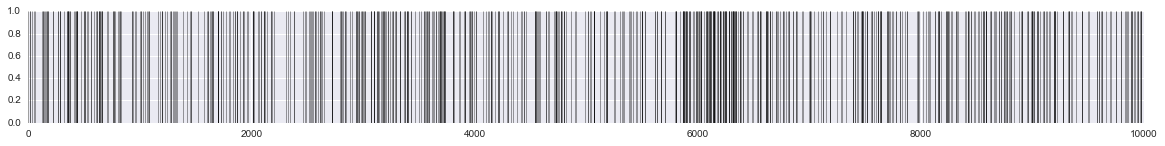

In [35]:
plt.figure(figsize=(20, 2))
plt.vlines([i for i,v in enumerate(totalSequenceAuthor[1000000:1000000+10000]) if v > 0], 0, 1, lw=.5, alpha=.75)

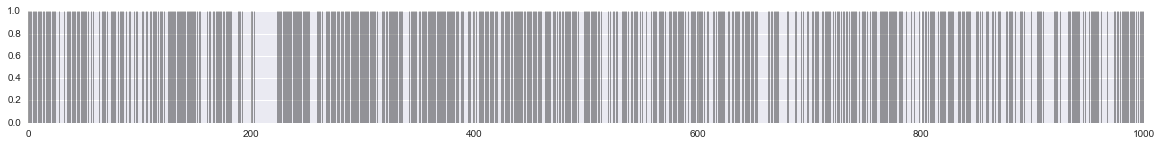

In [36]:
plt.figure(figsize=(20, 2))
plt.vlines([i for i,v in enumerate(totalSequenceEdges[1000000:1000000+1000]) if v > 0], 0, 1, lw=.5, alpha=.75)

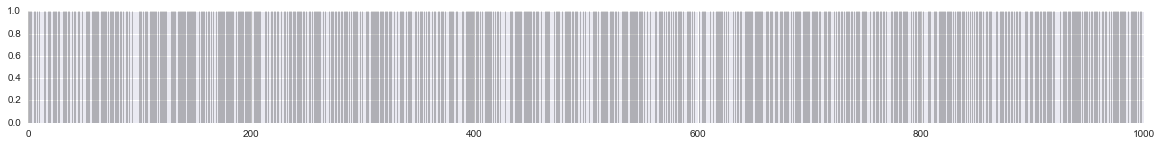

In [37]:
plt.figure(figsize=(20, 2))
plt.vlines([i for i,v in enumerate(totalSequenceCliques[200000:200000+1000]) if v > 0], 0, 1, lw=.5, alpha=.5)

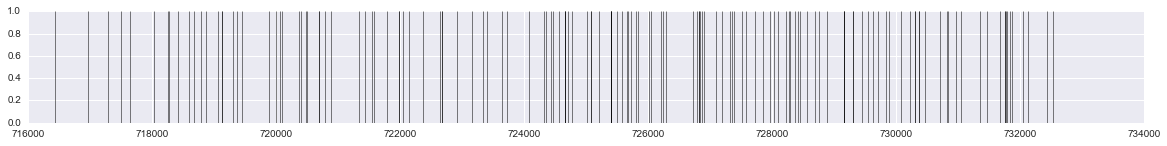

In [43]:
plt.figure(figsize=(20, 2))
selAuth = "172212"
plt.vlines([t for t,v in zip(Results[selAuth]["tRealPap"], Results[selAuth]["vPap"]) if v > 0], 0, 1, lw=1., alpha=.5)

In [44]:
def series2PE(sequence, times, slices, printout=False):
    if len(sequence) < 2:
        return None
    
    assert len(sequence) == len(times)
    
    IET = {s: [] for s in slices}
    
    for sl, IET_tmp in sorted(IET.iteritems()):
        t_ini, t_fin = 0, 1
        nburst = 0
        
        while True:
            while t_fin < len(sequence) and sequence[t_fin] == 0:
                t_fin += 1
            
            if t_fin < len(sequence):
                if times[t_fin] - times[t_ini] <= sl:
                    nburst += sum(sequence[t_ini:t_fin])
                    t_ini = t_fin
                    t_fin = t_ini + 1
                    continue
                else:
                    nburst += sum(sequence[t_ini:t_fin])
                    IET_tmp.extend([0]*(nburst - len(IET_tmp) + 1))
                    IET_tmp[nburst] += 1
                    
                    t_ini = t_fin
                    t_fin = t_ini + 1
                    nburst = 0
                    
            elif t_fin == len(sequence):
                if times[-1] - times[t_ini] <= sl:
                    nburst += sum(sequence[t_ini:])
                    IET_tmp.extend([0]*(nburst - len(IET_tmp) + 1))
                    IET_tmp[nburst] += 1
                break
        if printout: print sl
    return IET

In [18]:
IETauth = series2PE(totalSequenceAuthor, np.arange(len(totalSequenceAuthor)), [16,32,64,128,256])

In [19]:
IETedges = series2PE(totalSequenceEdges, np.arange(len(totalSequenceEdges)), [8,16,32,64])

In [20]:
IETcliques = series2PE(totalSequenceCliques, np.arange(len(totalSequenceCliques)), [8,16,32,64])

In [45]:
def plotPe(IET):
    for sl, res in sorted(IET.iteritems()):
        f, b = np.histogram(np.arange(len(res)), weights=res, density=True, bins=np.logspace(0, np.log10(len(res))))

        b = b[1:] + b[:-1]
        b /= 2.

        b = b[f>0]
        f = f[f>0]

        plt.loglog(b, f, ".-", label=r"$\delta t = %d$" % sl)

    plt.legend(loc=3)

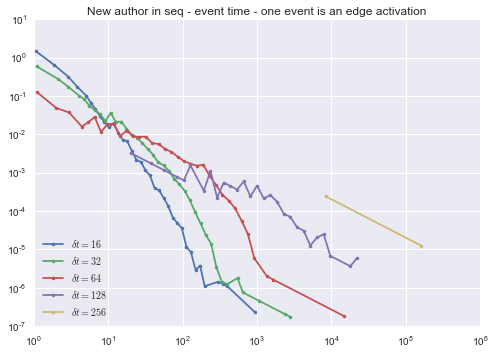

In [22]:
plotPe(IETauth)
plt.title("New author in seq - event time - one event is an edge activation")

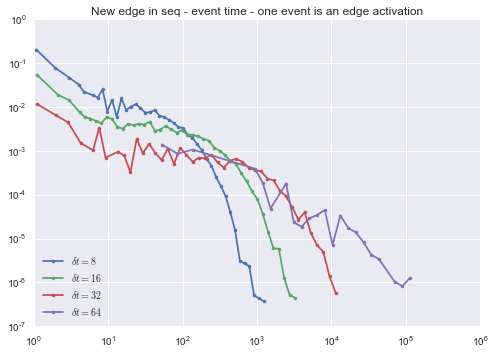

In [23]:
plotPe(IETedges)
plt.title("New edge in seq - event time - one event is an edge activation")

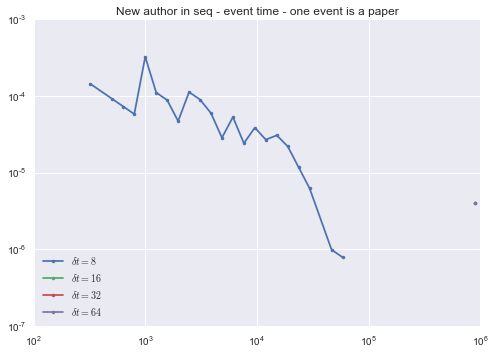

In [24]:
plotPe(IETcliques)
plt.title("New author in seq - event time - one event is a paper")

## New collaboration per author, time in edges activation and with multiplicity

In [27]:
PeRealTime = {}

# Results = {a: {"t": [], "v": [], "k": [], "tauth": [], "tev": [],\
#               "tRealPap": [], "tEvePap": [], "vPap": [], "tAuthPap": []}\

count = 0
for auth, values in Results.iteritems():
    tmp = series2PE(values["v"], values["t"], [30, 60, 120, 240, 480, 960])
    
    if not tmp:
        continue
        
    for sl, res in tmp.iteritems():
        PeRealTime.setdefault(sl, [])
        PeRealTime[sl].extend([0] * (len(res)-len(PeRealTime[sl])) )
                
        for i,v in enumerate(res):
            PeRealTime[sl][i] += v
    count += 1
    
    if count % 1e3 == 0:
        sys.stdout.write("\rAuth %09d of %09d done..." % (count, len(Results)))
        sys.stdout.flush()

Auth 000174000 of 000190997 done...

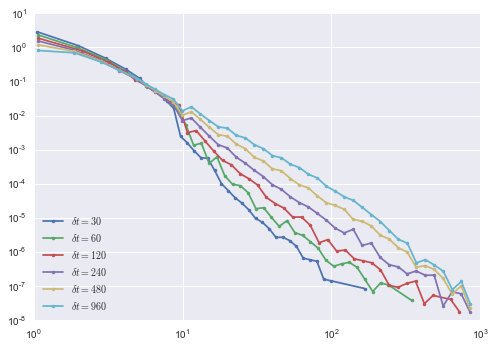

In [28]:
plotPe(PeRealTime)

## New collaboration per author, real time per paper, with multiplicity or not, depending on the case

In [54]:
PePaperRealTime = {}
PePaperRealTimeSingle = {}

# Results = {a: {"t": [], "v": [], "k": [], "tauth": [], "tev": [],\
#               "tRealPap": [], "tEvePap": [], "vPap": [], "tAuthPap": []}\

count = 0
for auth, values in Results.iteritems():
    # Results[selAuth]["tRealPap"], Results[selAuth]["vPap"]
    tmp = series2PE(values["vPap"], values["tRealPap"], [30, 60, 120, 240])
    tmp_single = series2PE([min(1,v) for v in values["vPap"]], values["tRealPap"],\
                           [120, 480, 960, 1200, 1500, 2000, 2500, 3000, 6000])
    
    if not tmp:
        continue
        
    if False:
        for sl, res in tmp.iteritems():
            PePaperRealTime.setdefault(sl, [])
            PePaperRealTime[sl].extend([0] * (len(res)-len(PePaperRealTime[sl])) )

            for i,v in enumerate(res):
                PePaperRealTime[sl][i] += v
    
    if True:
        for sl, res in tmp_single.iteritems():
            PePaperRealTimeSingle.setdefault(sl, [])
            PePaperRealTimeSingle[sl].extend([0] * (len(res)-len(PePaperRealTimeSingle[sl])) )

            for i,v in enumerate(res):
                PePaperRealTimeSingle[sl][i] += v
    
    
    count += 1
    
    if count % 1e3 == 0:
        sys.stdout.write("\rAuth %09d of %09d done..." % (count, len(Results)))
        sys.stdout.flush()

Auth 000111000 of 000190997 done...

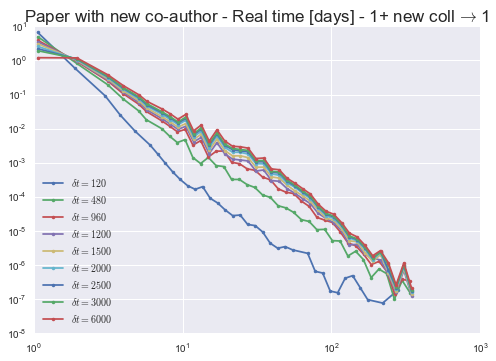

In [55]:
plotPe(PePaperRealTimeSingle)
plt.title(r"Paper with new co-author - Real time [days] - 1+ new coll $\to$ 1", size=17)

# Heaps law on events

In [ ]:
Dt = []
Dt_count = []

for auth, vals in Results.iteritems():
    while len(Dt) <= vals["tauth"][-1]:
        Dt.append(0)
        Dt_count.append(0)
    
    for nev, val in zip(vals["tauth"], vals["k"]):
        Dt[nev] += val
        Dt_count[nev] += 1


In [ ]:
Dt = np.array(Dt)
Dt_count = np.array(Dt_count)

Dt = Dt[Dt_count > 0]
Dt_count = Dt_count[Dt_count > 0]

plt.loglog(np.arange(len(Dt)), Dt/Dt_count, "o-")
plt.loglog(np.logspace(0,3), np.logspace(0,3))
plt.loglog(np.logspace(1.5,3.2), .8*np.logspace(1.5,3.2)**.9, lw=4)

# Barcode in total events, track appeareance of new authors

In [36]:
barcode = []
seenAuths = set()

# Build the list of events...
for tindex, fn in enumerate(fnames):
    with open(os.path.join(inDir, fn), "rb") as f:
        for l in f:
            auths = l.strip().split()
            new = 0
            for auth in auths:
                if auth not in seenAuths:
                    seenAuths.add(auth)
                    new = 1
            barcode.append(new)

In [40]:
slices = [i for i in np.arange(2, 50, 12)]
slices = [5, 10, 15, 20, 25]
results = {s: [] for s in slices}

for dt in slices:
    t_ini = barcode.index(1)
    t_fin = t_ini
    
    counter = 0
    while t_fin < len(barcode)-1:
        t_fin += 1
        if barcode[t_fin] == 0:
            continue
            
        if t_fin - t_ini <= dt:
            counter += 1
            t_ini = t_fin
            continue
            
        while(len(results[dt]) <= counter):
            results[dt].append(0)
        results[dt][counter] += 1
        
        t_ini = t_fin
        counter = 0
        


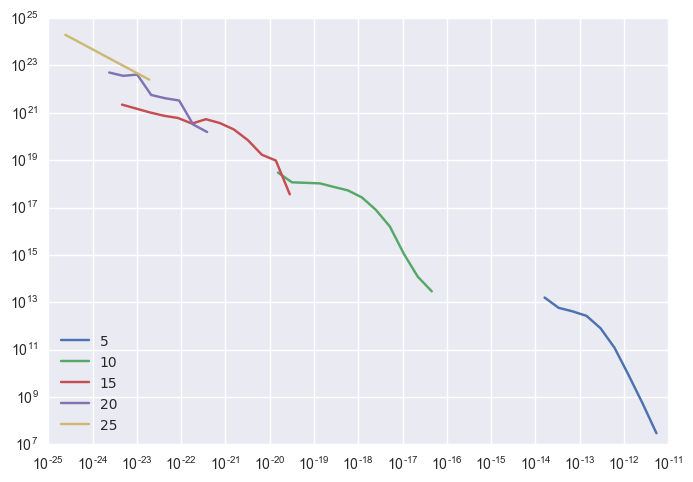

In [41]:
for dt, res in sorted(results.iteritems()):
    f, b = np.histogram(np.arange(len(res)), weights=res, density=True, bins=np.logspace(0, 6, 20))
    
    b = b[1:] + b[:-1]
    b /= 2.
    b = b[f>0]
    f = f[f>0]
    plt.loglog(b/dt**(1./(1-.95)), f*dt**(1./(1-.95)), label="%d"%dt)
    
plt.legend(loc=3)

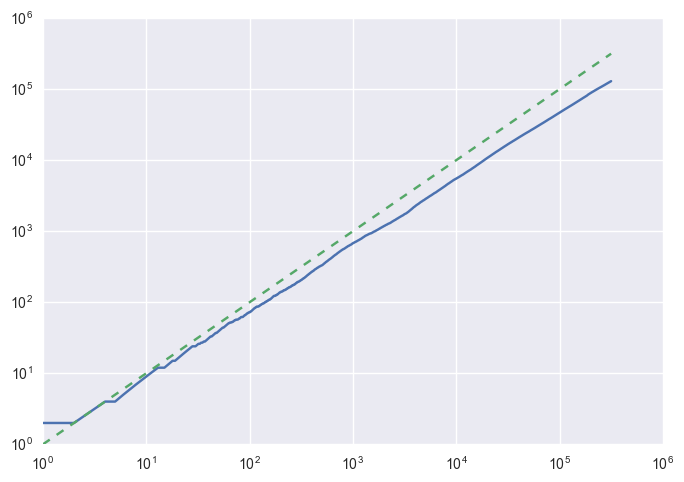

In [42]:
plt.loglog(range(len(barcode)), np.cumsum(barcode))
plt.loglog(range(len(barcode)), range(len(barcode)), '--')